# <span style='background:blue'>  <span style="color:orange"> ***Reviewer Note:*** **Begin PEP8 check cells (delete below when finished)**</span> </span>

In [ ]:
# disable all imported packages' loggers
import logging
logging.root.manager.loggerDict = {}

In [ ]:
%load_ext pycodestyle_magic
%flake8_on --ignore E261,E501,W291,W293

# only allow the checker to throw warnings when there's a violation
logging.getLogger('flake8').setLevel('ERROR')
logging.getLogger('stpipe').setLevel('ERROR')

# <span style='background:blue'>  <span style="color:orange"> ***Reviewer Note:*** **End PEP8 check cells (delete above when finished)**</span> </span>

In [ ]:
!pip install git+https://github.com/zclaytor/smartsnn

In [ ]:
from glob import glob
from copy import deepcopy

import numpy as np
from astropy.io import fits

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

from smartsnn.model import ConvNet
from smartsnn.model import Laplacian_NLL as loss_function

In [ ]:
pmax = 180

def scale_data(x):
    return x/pmax

def unscale_data(y):
    return y*pmax

class WaveletDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data_path, mode):
        """
        Args:
            mode (string): either train, val, or test
        """
        # need to handle mode; separate train/valid/test data
        if mode == "train":
            filenames = sorted(glob(data_path + "/001/*fits"))[0:3000:3] # How to read "all" data?
        elif mode == "val":
            filenames = sorted(glob(data_path + "/001/*fits"))[1:3001:3]
        elif mode == "test":
            filenames = sorted(glob(data_path + "/001/*fits"))[2:3002:3]

        periods = []
        wavelets = []
        
        for filename in filenames: # How to read "all" data?
            f = fits.open(filename)
            periods.append(f[0].header["PERIOD"])
            wavelets.append(f[2].data)
            f.close()
        self.wavelets = np.stack(wavelets)
        self.periods = np.array(periods)

    def __len__(self):
        return len(self.periods)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.wavelets[idx].astype('float32') 
        X = torch.tensor(X/255)
        X = torch.unsqueeze(X, 0)
        label = torch.tensor(self.periods[idx, np.newaxis])
        return X, label

In [ ]:
def train(model, train_loader, val_loader, num_epochs=100, early_stopping_patience=10, device=torch.device("cpu")):
    '''Train the neural network for all desired epochs.
    '''
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    # Set learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, factor=0.7, patience=3)

    # Training loop
    train_p_loss = []
    val_p_loss = []
    min_loss = 100
    early_stopping_count = 0
    best_epoch = 0

    for epoch in range(1, num_epochs + 1):
        p_loss = train_epoch(model, train_loader, optimizer, epoch, device=device)
        train_p_loss.append(p_loss)
        #p_loss = test(model, device, train_loader, epoch, mode="train", make_plot=True, verbose=False)
        p_loss = test(model, val_loader, epoch, mode="val")
        val_p_loss.append(p_loss)
        total_loss = p_loss
        scheduler.step(total_loss)    # learning rate scheduler

        if total_loss < min_loss:
            min_loss = total_loss
            early_stopping_count = 0
            best_epoch = epoch
            best_weights = deepcopy(model.state_dict())
        else:
            early_stopping_count += 1
            print(f'Early Stopping Count: {early_stopping_count}')
            if early_stopping_count == early_stopping_patience:
                print(f"Early Stopping. Best Epoch: {best_epoch} with loss {min_loss:.4f}.")
                with open("best_epoch.txt", "w") as f:
                    print(best_epoch, file=f)
                break    

    torch.save(best_weights, f"model.pt")
    return best_weights, train_p_loss, val_p_loss

def train_epoch(model, train_loader, optimizer, epoch, device=torch.device("cpu")):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train() # Set the model to training mode
    period_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = loss_function(output, target)
        loss.backward()                     # Gradient computation        
        optimizer.step()                    # Perform a single optimization step
        period_losses.append(loss.item())

        if (batch_idx*len(data)) % 10000 == 0:
            print('Epoch: {} [{}/{} ({:3.0f}%)] Training Loss: {:9.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), period_losses[-1]), end=" ")
    return np.mean(period_losses)

def test(model, test_loader, epoch=None, mode=None, verbose=True, device=torch.device("cpu")):
    model.eval()    # Set the model to inference mode
    test_p_loss = 0
    targets = []
    preds = []
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
            output = model(data)
            targets.extend(target.cpu().numpy())
            preds.extend(output.cpu().numpy())
            test_p_loss += loss_function(output, target, reduction='sum').item()

    test_p_loss /= len(test_loader.dataset)
    
    if verbose:
        print(f'Test loss: {test_p_loss:.4f}')
    return test_p_loss

def predict(model, test_loader, verbose=True, device=torch.device("cpu")):
    model.eval()    # Set the model to inference mode
    preds = []
    labels = []
    predicted = 0
    test_p_loss = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            labels.extend(np.array(target))
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
            output = model(data)
            test_p_loss += loss_function(output, target, reduction='sum').item()

            preds.extend(output.cpu().numpy())
            predicted += len(target)
            #print("Progress: {}/{}".format(predicted, len(test_loader.dataset)))

    test_p_loss /= len(test_loader.dataset)
    if verbose:
        print(f'Test loss: {test_p_loss:.4f}')


        return np.squeeze(preds), np.squeeze(labels)

In [12]:
train_dataset = WaveletDataset(data_path="data", mode="train")
valid_dataset = WaveletDataset(data_path="data", mode="val")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=50)

model = ConvNet()

weights, train_p_loss, val_p_loss = train(model, train_loader, val_loader,
    early_stopping_patience=10, num_epochs=500)

In [8]:
test_dataset = WaveletDataset(data_path="data", mode="test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50)

preds, trues = predict(model, test_loader, verbose=True)

Test loss: -0.2433


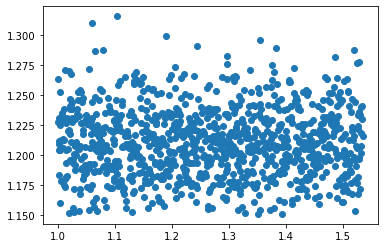

1: E999 SyntaxError: invalid syntax
5:27: E231 missing whitespace after ','


In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(trues, preds[:,0])